# Prepair

In [1]:
%load_ext autoreload
%autoreload 2

## Import

In [2]:
import os
os.chdir('../../code')
# What's in the current directory?

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# Import Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from torch import nn, optim

from data import TGSSaltDataset
from data.transforms import TGSTransform
from data.functional import collate_mask_fn

from utils.metrics import cal_mAP, cal_mIoU
from utils.viz import plot_mask_on_img

## Prepair Data

In [4]:
root_ds = '../dataset'
cross_validation = True
fold_val_idx = 1

Todo: Tìm hiểu cross validation và fold split

In [5]:
if not cross_validation:
    # DataFrame chứa toàn bộ train_id
    df = pd.read_csv(os.path.join(root_ds, 'train.csv'))
    df.drop('rle_mask', axis=1, inplace=True)
    df = pd.merge( df, pd.read_csv(os.path.join(root_ds, 'depths.csv')) , on='id', how='inner')
    total_sample = len(df.index)
    print('Total numper of sample:', total_sample)
    
    # Random split train/val=0.8/0.2
    train_size = int(0.8*total_sample)
    train_index, val_index = random_split(range(total_sample), [train_size, total_sample - train_size])
    
    train_df = df.loc[train_index.indices].reset_index()
    val_df = df.loc[val_index.indices].reset_index()
else:
    # DataFrame chứa toàn bộ train_id và đã được chia fold
    df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
    total_sample = len(df.index)
    print('Total numper of sample:', total_sample)

    train_df = df.loc[df.fold != 0].reset_index()
    val_df = df.loc[df.fold == 0].reset_index()

Total numper of sample: 4000


In [6]:
# Tạo dataset tương ứng với tập được chia
train_ds = TGSSaltDataset(root_ds, train_df, transforms=TGSTransform(augment=True, use_depth=False))
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment=False, use_depth=False)) # Không augmentation cho valid set
print(len(train_ds), len(val_ds))

3190 810


/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


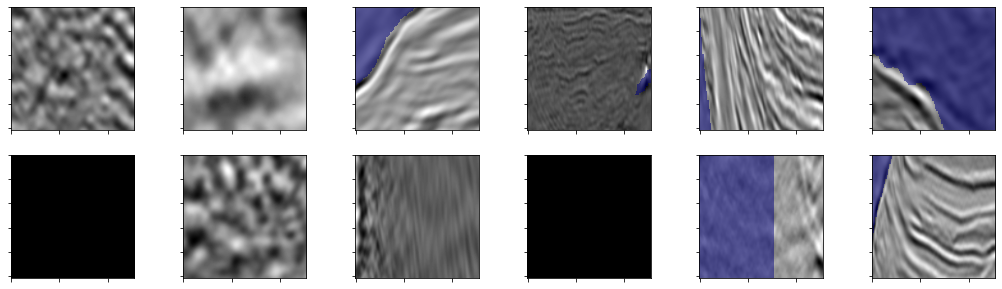

In [7]:
num_sample = 6
fig, axs = plt.subplots(2, num_sample, figsize=(3 * num_sample, 5))
for i in range(num_sample):
    img, mask = train_ds[i]
    img, mask = img.squeeze(), mask.squeeze()
    plot_mask_on_img(axs[0, i], img, mask > 0)
    img, mask = val_ds[i]
    img, mask = img.squeeze(), mask.squeeze()
    plot_mask_on_img(axs[1, i], img, mask > 0)

Create Dataloader

In [8]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

# Define Network

<img src="../../images/unet_arch.png">

In [9]:
from model.unet import DoubleConv, Down, Up, OutConv

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, num_filter1, num_down_stage, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, num_filter1)
        self.downs = [Down(num_filter1 * 2**i, num_filter1 * 2**(i + 1)) for i in range(num_down_stage - 1)]
        factor = 2 if bilinear else 1 # do bilinear khong half num feature
        self.downs.append(Down(num_filter1 * 2**(num_down_stage - 1), num_filter1 * 2**num_down_stage // factor))
        self.downs = nn.Sequential(*self.downs)

        self.ups = [Up(num_filter1 * 2**(num_down_stage - i) , num_filter1 * 2**(num_down_stage -1 - i) // factor, bilinear) for i in range(num_down_stage - 1)]
        self.ups.append(Up(num_filter1 * 2 , num_filter1 , bilinear))
        self.ups = nn.Sequential(*self.ups)
        self.outc = OutConv(num_filter1, n_classes)

    def forward(self, x):
        # Contrating path
        feature_blocks = [self.inc(x)]
        for down_module in self.downs:
            feature_blocks.append(down_module(feature_blocks[-1]))

        # Upsampling path
        resample_block = feature_blocks[-1]
        for i, up_module in enumerate(self.ups):
            resample_block = up_module(resample_block, feature_blocks[-i-2])
        
        # Segment
        logits = self.outc(resample_block)
        return logits

Todo: Giải thích code trên

# Trainging and Validation

* Loss func BCE

In [11]:
from utils.train import calculate_mAP
from torch.nn import functional as F
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
# Instantiate our model
model = UNet(1, 1, 16, 4)
model.to(device)
# Define our loss function
criterion =  F.binary_cross_entropy_with_logits
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

In [13]:
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downs): Sequential(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4):

In [14]:
def train_one_epoch(train_dl, model, criterion, optimizer):
    running_loss = 0
    model.train()
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        
        # Make predictions
        log_ps = model(images)
        
        bs = images.size(0)
        loss = criterion(log_ps.view(bs, -1, 1), labels.view(bs, -1, 1))
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_dl)

def eval_one_epoch(val_dl, model, criterion):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            bs = images.size(0)
            test_loss += criterion(log_ps.view(bs, -1, 1), labels.view(bs, -1, 1))

            mAP = cal_mAP(log_ps.detach(), labels.detach())
            accuracy += mAP
    return test_loss / len(val_dl), accuracy / len(val_dl)

def test_step(model, images, thress=0.5):
    images = images.to(device)
    model.eval()
    log_ps = model(images)
    return log_ps > thress

In [15]:
for e in range(epochs):
    train_epoch_loss = train_one_epoch(train_dl, model, criterion, optimizer)
    # Turn off gradients for validation
    valid_loss, acc = eval_one_epoch(val_dl, model, criterion)
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_epoch_loss),
          "Valid Loss: {:.3f}.. ".format(valid_loss),
          "Valid Accuracy: {:.3f}".format(acc))

Epoch: 1/25..  Training Loss: 0.432..  Valid Loss: 0.391..  Valid Accuracy: 0.445
Epoch: 2/25..  Training Loss: 0.368..  Valid Loss: 0.279..  Valid Accuracy: 0.565
Epoch: 3/25..  Training Loss: 0.334..  Valid Loss: 0.314..  Valid Accuracy: 0.464
Epoch: 4/25..  Training Loss: 0.320..  Valid Loss: 0.260..  Valid Accuracy: 0.588
Epoch: 5/25..  Training Loss: 0.294..  Valid Loss: 0.487..  Valid Accuracy: 0.551
Epoch: 6/25..  Training Loss: 0.301..  Valid Loss: 0.253..  Valid Accuracy: 0.591
Epoch: 7/25..  Training Loss: 0.287..  Valid Loss: 0.243..  Valid Accuracy: 0.556
Epoch: 8/25..  Training Loss: 0.277..  Valid Loss: 0.216..  Valid Accuracy: 0.624
Epoch: 9/25..  Training Loss: 0.270..  Valid Loss: 0.219..  Valid Accuracy: 0.612
Epoch: 10/25..  Training Loss: 0.262..  Valid Loss: 0.205..  Valid Accuracy: 0.660
Epoch: 11/25..  Training Loss: 0.252..  Valid Loss: 0.194..  Valid Accuracy: 0.619
Epoch: 12/25..  Training Loss: 0.262..  Valid Loss: 0.209..  Valid Accuracy: 0.635
Epoch: 13/25.

In [16]:
!mkdir -p ../params/basics
torch.save(model.state_dict(), '../params/basics/fold_{:02d}.pth'.format(fold_val_idx))

# Evaluation

In [17]:
val_iter = iter(val_dl)

In [18]:
images, masks = next(val_iter)
preds = test_step(model, images)

In [19]:
p = mIoU(torch.flatten(preds.cpu(), 1), torch.flatten(masks.cpu(), 1))
print(p)

NameError: name 'mIoU' is not defined

In [ ]:
num_sample = 6
fig, axs = plt.subplots(2, num_sample, figsize=(3 * num_sample, 5))
for i in range(num_sample):
    img, mask = images[i], masks[i]
    img, mask = img.squeeze().cpu().numpy(), mask.squeeze().cpu().numpy()
    plot_mask_on_img(axs[0, i], img, mask > 0)
    
    pred = preds[i]
    pred = pred.squeeze().cpu().numpy()
    plot_mask_on_img(axs[1, i], img, pred > 0)